# Importações

In [45]:
#!pip install scikit-learn shap pandas numpy matplotlib xgboost seaborn 

In [ ]:
import pickle

import shap
import matplotlib.pyplot as plt

import pandas as pd 
import numpy as np  

# Pré-processamento e pipelines
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Modelos de ML
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Validação e busca de hiperparâmetros
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform, loguniform

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

# Transformadores personalizados
from transformers_Com_Nulos import DateFeatureExtractor, CapTransformer, RareCategoryGrouper

# Carregando dataset

In [47]:
# Carregar o dataset
df = pd.read_csv('./filmes_com_nulos.csv')

# Dividindo os dados
- X_train, X_test, y_train, y_test

In [48]:
numerical_cols = df[['popularity', 'budget', 'runtime']].columns
categorical_col = ['original_language']
date_column = 'release_date'

X = df.drop(columns=['vote_average'])
y = df['vote_average']

# Dividindo o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=87)

# Transformadores
- MultiLabelBinarize -> Generos Cinematográficos e Produtora
- Data -> Extrai o ano e o mês das datas
- Outliers -> Cap, Log + Cap, Winsorizer
- Agrupamento de categorias raras -> original language

### Colunas: Generos Cinematográficos e Produtora
Aplicando MultiLabelBinarize com limites de 12 e 10, respectivamente

In [49]:
def process_multilabel_column(train_series, test_series, sep='-', top_n=20, outros=True, prefix=''):
    # Extrair top N do treino
    exploded = train_series.str.split(sep).explode().str.strip()
    top = exploded.value_counts().nlargest(top_n).index

    def filter_top(vals):
        vals = [v.strip() for v in vals.split(sep)]
        if outros:
            return [v if v in top else 'Outros' for v in vals]
        else:
            return [v for v in vals if v in top]

    # Aplicar transformação
    train_processed = train_series.apply(filter_top)
    test_processed = test_series.apply(filter_top)

    mlb = MultiLabelBinarizer()
    train_encoded = pd.DataFrame(
        mlb.fit_transform(train_processed),
        columns=[f'{prefix}_{cls}' for cls in mlb.classes_],
        index=train_series.index
    )
    test_encoded = pd.DataFrame(
        mlb.transform(test_processed),
        columns=[f'{prefix}_{cls}' for cls in mlb.classes_],
        index=test_series.index
    )

    return train_encoded, test_encoded, mlb


#### Generos cinematográficos

In [50]:
teste = X_train['genres'].dropna().apply(lambda x: x.split('-')).copy()
teste = teste.explode().reset_index(drop=True)
genre_counts = teste.value_counts() # Apply value_counts directly to the Series
print(genre_counts)
print(len(genre_counts))

genres
Drama              5858
Comedy             4013
Thriller           3065
Action             2802
Horror             2006
Romance            1987
Crime              1704
Adventure          1700
Science Fiction    1278
Family             1046
Fantasy            1016
Mystery             930
History             662
Documentary         542
Animation           538
War                 469
Music               437
Western             196
TV Movie            148
Name: count, dtype: int64
19


In [51]:
from sklearn.preprocessing import MultiLabelBinarizer

def process_multilabel_column(train_series, test_series, sep='-', top_n=20, outros=True, prefix=''):
    # Tratar valores nulos como listas vazias
    train_series = train_series.fillna('')
    test_series = test_series.fillna('')

    # Extrair top N categorias do treino
    exploded = train_series.str.split(sep).explode().str.strip()
    top = exploded.value_counts().nlargest(top_n).index

    def filter_top(vals):
        vals = [v.strip() for v in vals.split(sep) if v.strip()]
        if outros:
            return [v if v in top else 'Outros' for v in vals]
        else:
            return [v for v in vals if v in top]

    train_processed = train_series.apply(filter_top)
    test_processed = test_series.apply(filter_top)

    mlb = MultiLabelBinarizer()
    train_encoded = pd.DataFrame(
        mlb.fit_transform(train_processed),
        columns=[f'{prefix}_{cls}' for cls in mlb.classes_],
        index=train_series.index
    )
    test_encoded = pd.DataFrame(
        mlb.transform(test_processed),
        columns=[f'{prefix}_{cls}' for cls in mlb.classes_],
        index=test_series.index
    )

    return train_encoded, test_encoded, mlb


In [52]:
genres_train, genres_test, mlb_genres= process_multilabel_column(
    X_train['genres'], X_test['genres'], sep='-', top_n=12, outros=True, prefix='genre'
)

# Substituir a coluna original
X_train = X_train.drop(columns='genres').join(genres_train)
X_test = X_test.drop(columns='genres').join(genres_test)

##### Definindo Pickle

In [53]:
#with open('mlb_genres.pkl', 'wb') as f:
    #pickle.dump(mlb_genres, f)

#### Produtoras

In [54]:
teste = X_train['production_companies'].apply(lambda x: x.split('-') if pd.notnull(x) else []).copy()
teste = teste.explode().reset_index(drop=True)
production_counts = teste.value_counts() # Apply value_counts directly to the Series
print(production_counts[:8])
print(len(production_counts))

production_companies
Warner Bros. Pictures    558
Universal Pictures       520
20th Century Fox         400
Paramount                384
Columbia Pictures        379
Goldwyn                  321
Metro                    319
Mayer                    308
Name: count, dtype: int64
14776


In [55]:
production_train, production_test, mlb_production = process_multilabel_column(
    X_train['production_companies'], X_test['production_companies'], sep='-', top_n=8, outros=True, prefix='production'
)

# Substituir a coluna original
X_train = X_train.drop(columns='production_companies').join(production_train)
X_test = X_test.drop(columns='production_companies').join(production_test)

##### Definindo pickle 

In [56]:
#with open('mlb_production.pkl', 'wb') as f:
    #pickle.dump(mlb_production, f)

# Treinamento
- Modelo XGBRegressor
- Modelo SVR
- Modelo RandomForest

### Definindo Kf

In [57]:
# Definindo o KFold para o cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=87)

In [58]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class CapTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, factor=1.5):
        self.columns = columns
        self.factor = factor
        self.caps_ = {}

    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            for col in self.columns:
                Q1 = X[col].quantile(0.25)
                Q3 = X[col].quantile(0.75)
                IQR = Q3 - Q1
                upper_bound = Q3 + self.factor * IQR
                self.caps_[col] = upper_bound
        else:
            # Quando X é um array numpy, os índices são posições
            for idx, col in enumerate(self.columns):
                Q1 = np.percentile(X[:, idx], 25)
                Q3 = np.percentile(X[:, idx], 75)
                IQR = Q3 - Q1
                upper_bound = Q3 + self.factor * IQR
                self.caps_[idx] = upper_bound
        return self

    def transform(self, X):
        X_copy = X.copy()
        if isinstance(X_copy, pd.DataFrame):
            for col in self.columns:
                X_copy[col] = np.minimum(X_copy[col], self.caps_[col])
        else:
            # array numpy
            for idx in range(X_copy.shape[1]):
                X_copy[:, idx] = np.minimum(X_copy[:, idx], self.caps_[idx])
        return X_copy


### XGBRegressor

In [59]:
# Cap de outliers + padronização
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # adiciona esse
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

# OneHot para variáveis categóricas
cat_pipeline = Pipeline([
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Pré-processador geral
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder='passthrough')  # passa as colunas de ano/mês e binarizadas


# Pipeline Completo
pipeline = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),  # extrai year e month
    ('preprocess', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=87, n_jobs=-1))
])

# RandomizedSearch
param_dist = {
    'regressor__n_estimators': randint(100, 300),
    'regressor__max_depth': randint(3, 10),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__subsample': uniform(0.7, 0.3),
    'regressor__colsample_bytree': uniform(0.7, 0.3),
}

kf = KFold(n_splits=5, shuffle=True, random_state=87)

XGBRegressor_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=30,
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

# Treinamento e resultado
XGBRegressor_rand.fit(X_train, y_train)

print("Melhores parâmetros:", XGBRegressor_rand.best_params_)
print("Melhor R² (validação cruzada):", XGBRegressor_rand.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros: {'regressor__colsample_bytree': 0.8696231377727208, 'regressor__learning_rate': 0.05992056035524427, 'regressor__max_depth': 5, 'regressor__n_estimators': 241, 'regressor__subsample': 0.8173221947525602}
Melhor R² (validação cruzada): 0.4172628547179896


### SVR

In [60]:
# Pipeline para numéricas com cap e padronização
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # adiciona esse
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])


# Pipeline para categóricas com OneHot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # <- ADICIONE ISSO
    ('rare', RareCategoryGrouper(column='original_language', top_n=10, other_label='Other')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

from sklearn.pipeline import make_pipeline

# Crie um imputer genérico para o restante
remainder_imputer = make_pipeline(
    SimpleImputer(strategy='most_frequent')  # ou 'constant' com fill_value=0 se preferir
)

# Atualize o preprocessor
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder=remainder_imputer)

pipeline = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),  # extrai 'year' e 'month'
    ('preprocess', preprocessor),
    ('regressor', SVR())
])

param_dist = {
    'regressor__kernel': ['rbf', 'linear'],
    'regressor__C': loguniform(1e-2, 1e2),
    'regressor__epsilon': uniform(0.01, 0.3),
    'regressor__gamma': ['scale', 'auto']
}


svm_rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=20,  
    cv=kf,
    scoring='r2',
    random_state=87,
    verbose=2,
    n_jobs=-1
)

svm_rand.fit(X_train, y_train)

print("Melhores parâmetros:", svm_rand.best_params_)
print("Melhor R² (validação cruzada):", svm_rand.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Melhores parâmetros: {'regressor__C': 24.47615312823446, 'regressor__epsilon': 0.25628822239245164, 'regressor__gamma': 'auto', 'regressor__kernel': 'rbf'}
Melhor R² (validação cruzada): 0.2706654758207934


### RandomForest

In [61]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # adiciona esse
    ('cap', CapTransformer(columns=numerical_cols)),
    ('scale', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('cat', cat_pipeline, categorical_col)
], remainder='passthrough')


# --- Pipeline final com RandomForest ---
pipeline_rf = Pipeline([
    ('date', DateFeatureExtractor(date_column=date_column)),
    ('preprocess', preprocessor),
    ('regressor', RandomForestRegressor(random_state=87, n_jobs=-1))
])


# --- Espaço de busca para RandomizedSearchCV ---
param_dist_rf = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__max_depth': randint(3, 20),
    'regressor__min_samples_split': randint(2, 10),
    'regressor__min_samples_leaf': randint(1, 10),
    'regressor__max_features': ['sqrt', 'log2', None]
}

rf_rand = RandomizedSearchCV(
    estimator=pipeline_rf,
    param_distributions=param_dist_rf,
    n_iter=30,
    cv=kf,
    scoring='r2',
    error_score='raise',     
    random_state=87,
    verbose=2,
    n_jobs=-1
)

# --- Treino e outputs ---
rf_rand.fit(X_train, y_train)

print("Melhores parâmetros RF:", rf_rand.best_params_)
print("Melhor R² (CV) RF:", rf_rand.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Melhores parâmetros RF: {'regressor__max_depth': 15, 'regressor__max_features': None, 'regressor__min_samples_leaf': 5, 'regressor__min_samples_split': 8, 'regressor__n_estimators': 499}
Melhor R² (CV) RF: 0.4160707074939779


# Gerando modelos Treinados

In [62]:
'''
with open('xgb_pipeline.pkl', 'wb') as f:
    pickle.dump(XGBRegressor_rand, f)

with open('svr_pipeline.pkl', 'wb') as f:
    pickle.dump(svm_rand, f)

with open('rf_pipeline.pkl', 'wb') as f:
    pickle.dump(rf_rand, f)
'''

"\nwith open('xgb_pipeline.pkl', 'wb') as f:\n    pickle.dump(XGBRegressor_rand, f)\n\nwith open('svr_pipeline.pkl', 'wb') as f:\n    pickle.dump(svm_rand, f)\n\nwith open('rf_pipeline.pkl', 'wb') as f:\n    pickle.dump(rf_rand, f)\n"

# Avaliação dos modelos

In [63]:
def evaluate_model(model_name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Modelo': model_name,
        'R²': r2_score(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MedAE': median_absolute_error(y_test, y_pred)
    }


In [64]:
results = []

results.append(evaluate_model("XGBRegressor", XGBRegressor_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("SVR", svm_rand.best_estimator_, X_test, y_test))
results.append(evaluate_model("RandomForestRegressor", rf_rand.best_estimator_, X_test, y_test))

results_df = pd.DataFrame(results)
print(results_df)

                  Modelo        R²       MAE      RMSE     MedAE
0           XGBRegressor  0.434685  0.926707  1.485369  0.534090
1                    SVR  0.275346  1.058103  1.681723  0.600451
2  RandomForestRegressor  0.431939  0.932873  1.488972  0.534861


# Gráficos

In [65]:
# Erro de importação do SHAP com o numpy 

#!pip uninstall numpy
#!pip install numpy==1.22.4 

                    feature  importance
0                popularity    0.130511
5      original_language_en    0.070314
21             genre_Horror    0.059610
23             genre_Outros    0.048248
18              genre_Drama    0.047190
2                   runtime    0.043343
36                     year    0.042034
10     original_language_it    0.037016
3   original_language_Other    0.032634
1                    budget    0.028695


100%|===================| 12857/12886 [00:56<00:00]        

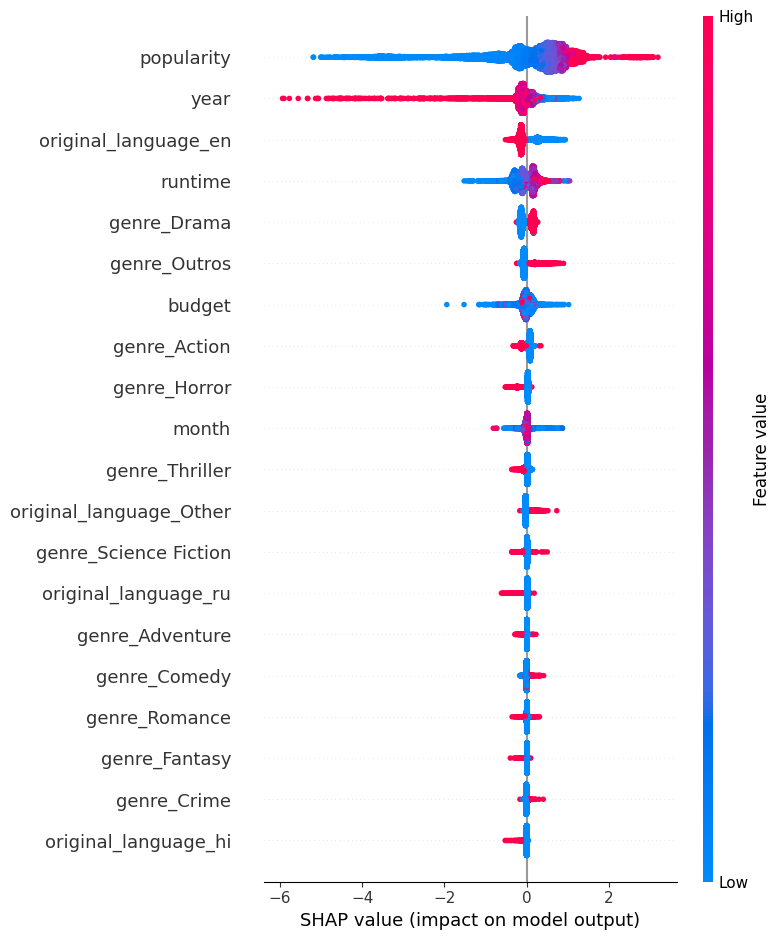

In [66]:
# Extrair o modelo XGBRegressor treinado do pipeline
xgb_model = XGBRegressor_rand.best_estimator_.named_steps['regressor']

# Extrair as features após o processamento
# Precisamos transformar X_train para obter as features corretas
X_train_transformed = XGBRegressor_rand.best_estimator_.named_steps['preprocess'].transform(
    XGBRegressor_rand.best_estimator_.named_steps['date'].transform(X_train)
)

# Obter os nomes das features após o ColumnTransformer
feature_names = []
# num_pipeline features
feature_names += list(numerical_cols)
# cat_pipeline features
cat_features = X_train[categorical_col[0]].unique()
cat_feature_names = XGBRegressor_rand.best_estimator_.named_steps['preprocess'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_col)
feature_names += list(cat_feature_names)
# remainder (multilabels, year, month)
remainder = [col for col in X_train.columns if col not in numerical_cols and col not in categorical_col and col != date_column]
feature_names += remainder + ['year', 'month']

# Feature importances do XGBoost
importances = xgb_model.feature_importances_

# Exibir as 10 features mais importantes
importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(importances_df.sort_values('importance', ascending=False).head(10))

# SHAP
explainer = shap.Explainer(xgb_model, X_train_transformed, feature_names=feature_names)
shap_values = explainer(X_train_transformed)

# Resumo SHAP
shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names)

In [67]:
pd.set_option('display.max_rows', None)
display(importances_df.sort_values('importance', ascending=False))
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

,feature,importance
0,popularity,0.130511
5,original_language_en,0.070314
21,genre_Horror,0.059610
23,genre_Outros,0.048248
18,genre_Drama,0.047190
2,runtime,0.043343
36,year,0.042034
10,original_language_it,0.037016
3,original_language_Other,0.032634
1,budget,0.028695
